In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm

In [2]:
def pdf_1(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

def pdf_2(x, mean, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mean)**2/(2*var))

In [3]:
from scipy.integrate import simps

def compute_analytic_JSD(mean1, var1, mean2, var2):
    xmin = min(mean1 - 5 * np.sqrt(var1), mean2 - 5 * np.sqrt(var2))
    xmax = max(mean1 + 5 * np.sqrt(var1), mean2 + 5 * np.sqrt(var2))
    x_grid = np.linspace(xmin, xmax, 1000000)
    pdf1 = pdf_1(x_grid, mean1, var1)
    pdf2 = pdf_2(x_grid, mean2, var2)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def compute_analytic_JSD_2(f1, f2):
    x_grid = np.linspace(-10., 10., 1000000)
    pdf1 = f1(x_grid)
    pdf2 = f2(x_grid)
    kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
    kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
    return 0.5 * (kl1 + kl2)

def generate_data_1(mean_1, var_1, N):
    return np.random.normal(mean_1, np.sqrt(var_1), N)

def generate_data_2(mean_2, var_2, N):
    return np.random.normal(mean_2, np.sqrt(var_2), N)

def compute_JSD(result1, result2, interpolation='quadratic', binning="FD"):    
    if binning == "FD":
        number_of_bins_1 = int((result1.max() - result1.min())/(2*iqr(result1)*result1.size**(-1/3)))
    elif binning == "S":
        number_of_bins_1 = int(1 + np.log2(result1.size))
    elif binning == "fuckit50":
        number_of_bins_1 = 50
    if number_of_bins_1 < 5:
        number_of_bins_1 = 5
    nbins1 = np.linspace(result1.min(), result1.max(), number_of_bins_1)

    if binning == "FD":
        number_of_bins_2 = int((result2.max() - result2.min())/(2*iqr(result2)*result2.size**(-1/3)))
    elif binning == "S":
        number_of_bins_2 = int(1 + np.log2(result2.size))
    elif binning == "fuckit50":
        number_of_bins_2 = 50
    if number_of_bins_2 < 5:
        number_of_bins_2 = 5
    nbins2 = np.linspace(result2.min(), result2.max(), number_of_bins_2)
    h, bins = np.histogram(
        result1, density=True, bins=nbins1
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])

    min1, max1 = bin_centres[0], bin_centres[-1]
    fit1 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)

    h, bins = np.histogram(
        result2, density=True, bins=nbins2
    )
    bin_centres = 0.5 * (bins[1:] + bins[0:-1])
    min2, max2 = bin_centres[0], bin_centres[-1]
    fit2 = interp1d(bin_centres, h, kind=interpolation, fill_value=0.0, bounds_error=False)
    x_grid = np.linspace(min(min1, min2), max(max1, max2), 1000)

    def fit_1(x):
        return max(1e-10, fit1(x))

    def fit_2(x):
        return max(1e-10, fit2(x))


    fit_1 = np.vectorize(fit_1)
    fit_2 = np.vectorize(fit_2)

    JSD = jensenshannon(fit_1(x_grid), fit_2(x_grid))**2
    return JSD, fit_1, fit_2

In [44]:
mean_1, var_1 = 0., 1.
mean_2, var_2 = 0., 1.
N = 100000

In [45]:
N_samples = 200
N_points = 50
mean_start = 1.
mean_end = 0.
mean_factor = (mean_start - mean_end)/(N_points - 1)
mean_list = np.array([mean_start - mean_factor*i for i in range(N_points)])
true_jsds = np.zeros((N_points))
estimated_jsds = np.zeros((N_points, N_samples))
for i, mean in tqdm(enumerate(mean_list)):
    true_jsd = compute_analytic_JSD(mean_1, 1.0, mean, 1.0)
    print(true_jsd)

0it [00:00, ?it/s]/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
3it [00:00, 22.52it/s]

0.1114212893800709
0.10738445543867042
0.1033969753345386
0.0994605408918344
0.09557684337240355


9it [00:00, 23.32it/s]

0.09174757229746786
0.08797441423298726
0.08425905153852942
0.08060316107955212
0.07700841290309915
0.07347646887700156


15it [00:00, 23.62it/s]

0.07000898129279301
0.06660759143266756
0.06327392810094554
0.060009606120666324
0.05681622479609137


21it [00:00, 23.39it/s]

0.053695366342084924
0.050648594281539464
0.04767745181222853
0.04478346014470836
0.041968116813138306


24it [00:01, 23.03it/s]

0.03923289396116692
0.03657923660531664
0.03400856087861083
0.03152225225751052
0.029121663775569254


30it [00:01, 22.88it/s]

0.026808114227568486
0.024582886368263265
0.022447225110240675
0.02040233572577488
0.0184493820579412


36it [00:01, 22.26it/s]

0.01658948474662824
0.014823719475450737
0.013153115245913312
0.011578652685498786
0.010101262396642444


39it [00:01, 22.14it/s]

0.008721823353802767
0.0074411613560347095
0.006260047542609532
0.005179196979291428
0.00419926732287162


45it [00:02, 21.32it/s]

0.0033208575714641204
0.0025445069078785364
0.001870693643099804
0.0012998342665180222
0.0008322826090649453


50it [00:02, 22.35it/s]

0.0004683291248276639
0.0002082002960310416
5.205816551579848e-05
2.9935246099503054e-18


In [46]:
for i, mean in tqdm(enumerate(mean_list)):
    true_jsd = compute_analytic_JSD(mean_1, 1.0, mean, 1.0)
    for j in range(N_samples):
        result1 = generate_data_1(mean_1, 1.0, N)
        result2 = generate_data_2(mean, 1.0, N)
        JSD, fit_1, fit_2 = compute_JSD(result1, result2)
        estimated_jsds[i, j] = JSD
    true_jsds[i] = true_jsd

0it [00:00, ?it/s]/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
50it [05:56,  7.13s/it]


In [48]:
np.save(f"/Users/james/Code/doppel/jsd/true_jsds_means_N_{N}.npy", true_jsds)
np.save(f"/Users/james/Code/doppel/jsd/estimated_jsds_means_N_{N}.npy", estimated_jsds)

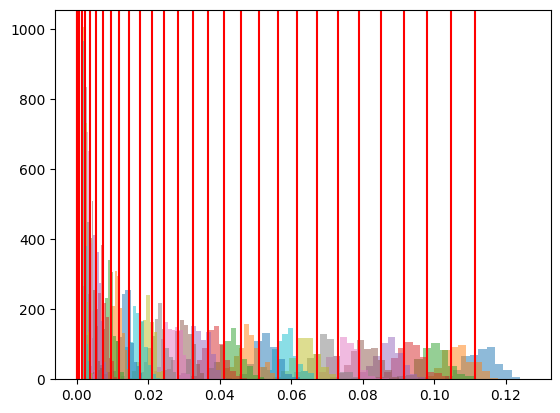

In [10]:
for i in range(N_points):
    plt.hist(estimated_jsds[i,:], bins=10, density=True, alpha=0.5)
    plt.axvline(true_jsds[i], color='red')
plt.show()

Text(0.5, 1.0, 'N = 100000')

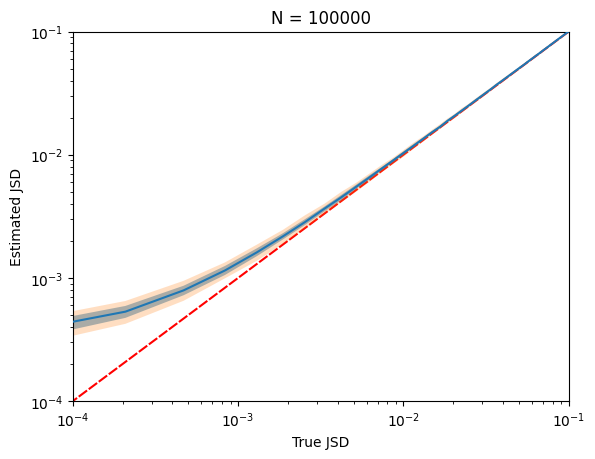

In [47]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 100000')

In [61]:
N = 100000
N_samples = 200
N_points = 50
var_start = 5**2
var_end = 1.01**2
var_factor = np.exp(np.log(var_end/var_start)/(N_points-1))
var_list = np.array([var_start*var_factor**i for i in range(N_points)])
vtrue_jsds = np.zeros((N_points))
vestimated_jsds = np.zeros((N_points, N_samples))
for i, variance in tqdm(enumerate(var_list)):
    vtrue_jsd = compute_analytic_JSD(mean_1, 1.0, mean_2, variance)
    for j in range(N_samples):
        result1 = generate_data_1(mean_1, 1.0, N)
        result2 = generate_data_2(mean_2, variance, N)
        JSD, fit_1, fit_2 = compute_JSD(result1, result2)
        vestimated_jsds[i, j] = JSD
    vtrue_jsds[i] = vtrue_jsd

0it [00:00, ?it/s]/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl1 = simps((pdf1 * np.log(pdf1 / (0.5 * (pdf1 + pdf2)))), x_grid)
/var/folders/rr/6sbz4k1945v0s9xvs3ldc3ch0000gn/T/ipykernel_39832/3536944162.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  kl2 = simps((pdf2 * np.log(pdf2 / (0.5 * (pdf1 + pdf2)))), x_grid)
50it [05:54,  7.09s/it]


Text(0.5, 1.0, 'N = 100000')

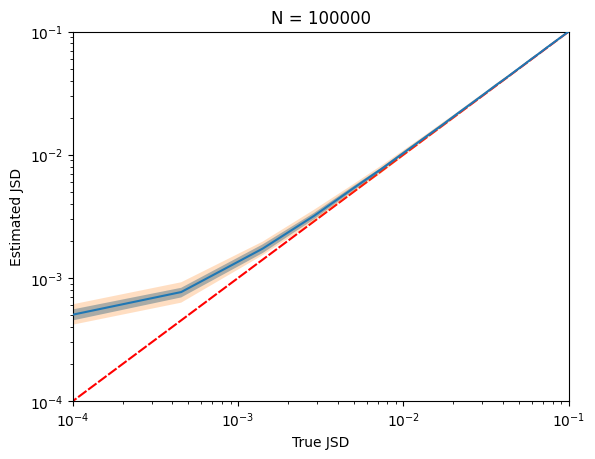

In [62]:
plt.plot(vtrue_jsds, np.quantile(vestimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(vtrue_jsds, vtrue_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.16, axis=1), np.quantile(vestimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.025, axis=1), np.quantile(vestimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title(f'N = {N}')

In [63]:
np.save(f"/Users/james/Code/doppel/jsd/true_jsds_vars_N_{N}.npy", vtrue_jsds)
np.save(f"/Users/james/Code/doppel/jsd/estimated_jsds_vars_N_{N}.npy", vestimated_jsds)

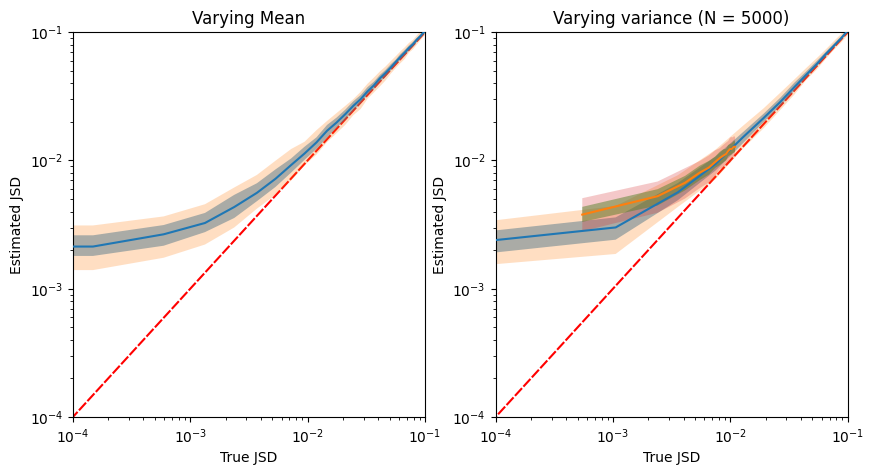

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title("Varying Mean")

ax = plt.subplot(1, 2, 2)
plt.plot(vtrue_jsds, np.quantile(vestimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(vtrue_jsds, vtrue_jsds, color='r', ls=(1, (5, 1)), zorder=-10)

plt.plot(true_t, np.quantile(est_t, 0.5, axis=1), zorder=10)

plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.16, axis=1), np.quantile(vestimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(vtrue_jsds, np.quantile(vestimated_jsds, 0.025, axis=1), np.quantile(vestimated_jsds, 0.975, axis=1), alpha=0.25)

plt.fill_between(true_t, np.quantile(est_t, 0.16, axis=1), np.quantile(est_t, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_t, np.quantile(est_t, 0.025, axis=1), np.quantile(est_t, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4, 1e-1)
plt.ylim(1e-4, 1e-1)
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('Varying variance (N = 5000)')
plt.show()

In [19]:
est_t = np.load('/Users/james/Code/doppel/jsd/jsd_data.npy')
true_t = np.load('/Users/james/Code/doppel/jsd/jsd_true.npy')

Text(0.5, 1.0, 'N = 10000')

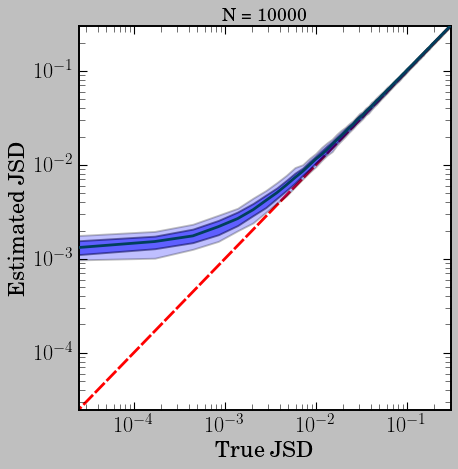

In [45]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 10000')

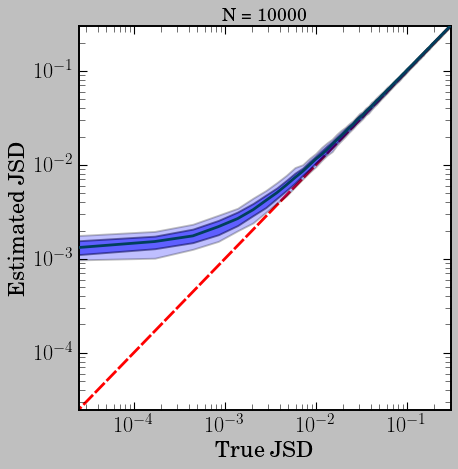

In [48]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 10000')

Text(0.5, 1.0, 'N = 5000')

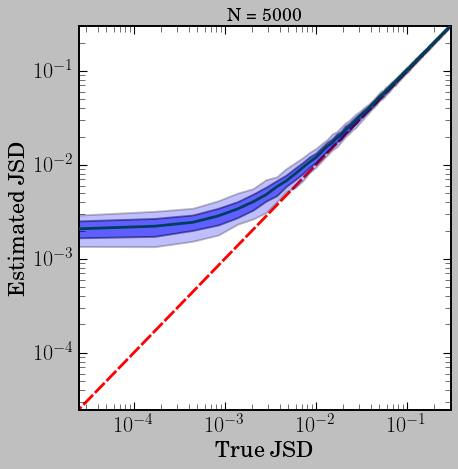

In [52]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(true_jsds[-1], true_jsds[0])
plt.ylim(true_jsds[-1], true_jsds[0])
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')

Text(0.5, 1.0, 'N = 5000')

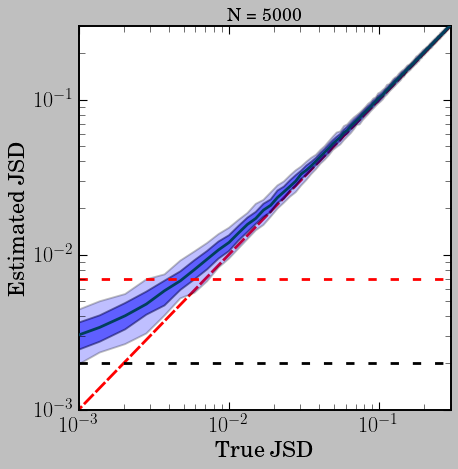

In [61]:
plt.plot(true_jsds, np.quantile(estimated_jsds, 0.5, axis=1), zorder=10)
plt.plot(true_jsds, true_jsds, color='r', ls=(1, (5, 1)), zorder=-10)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.16, axis=1), np.quantile(estimated_jsds, 0.84, axis=1), alpha=0.5)
plt.fill_between(true_jsds, np.quantile(estimated_jsds, 0.025, axis=1), np.quantile(estimated_jsds, 0.975, axis=1), alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3, 3e-1)
plt.ylim(1e-3, 3e-1)
plt.axhline(2e-3, color='k', ls='--')
plt.axhline(7e-3, color='r', ls='--')
plt.xlabel('True JSD')
plt.ylabel('Estimated JSD')
plt.title('N = 5000')